In [26]:
import os
from collections import deque
import platform
import random
from tqdm import tqdm

import gym
import numpy as np
import PIL.Image as Image
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import Dense, Input

from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

tf.keras.mixed_precision.set_global_policy('mixed_float16')  # Enable mixed precision
tf.config.run_functions_eagerly(False)  # Disable eager execution
tf.random.set_seed(42) # Reproducibility random seed

print (
f'''
Python version: {platform.python_version()}
TensorFlow version: {tf.__version__}
Gym version: {gym.__version__}
NumPy version: {np.__version__}
Matplotlib version: {matplotlib.__version__}
'''
)


Python version: 3.9.13
TensorFlow version: 2.19.0
Gym version: 0.24.0
NumPy version: 2.0.2
Matplotlib version: 3.9.4



In [36]:
# Hyperparameters
MEMORY_SIZE = 10000
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
EPISODES = 1000
TIME_STEPS = 1000
TARGET_UPDATE_FREQUENCY = 10
MINIMUM_REWARD = 200.0

In [37]:
# Create the Lunar Lander Environment
'''
The agent has four discrete actions available, each corresponding to a numerical value:

Do nothing= 0
Fire right engine= 1
Fire main engine= 2
Fire left engine= 3
'''
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape
action_size = env.action_space.n

print(f"state_size: {state_size}")
print(f"action_size: {action_size}")

state_size: (8,)
action_size: 4


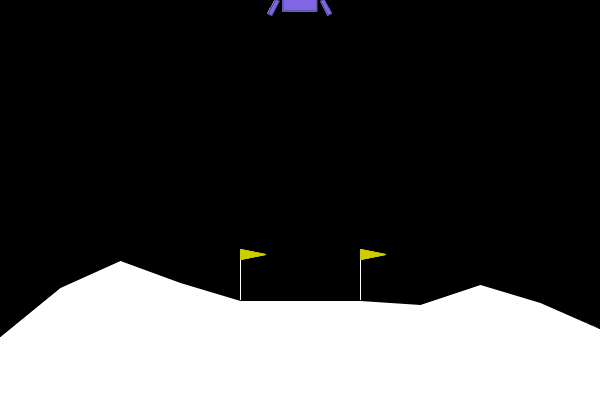

In [38]:
env.reset()
Image.fromarray(env.render(mode= 'rgb_array'))

In [39]:
# Building the Neural Network Model
def build_model(state_size, action_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=state_size),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(action_size, activation="linear")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="mse")
    return model

model = build_model(state_size, action_size)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,996 (19.52 KB)

 Trainable params: 4,996 (19.52 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Implement the DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, gamma, epsilon, epsilon_min, epsilon_decay):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.update_target_model()
        self.target_update_frequency = TARGET_UPDATE_FREQUENCY
        self.checkpoint_path = "./checkpoints/best_model.keras"

    def save_checkpoint(self):
        os.makedirs("checkpoints", exist_ok=True)
        self.model.save(self.checkpoint_path)
        print(f"Checkpoint saved to {self.checkpoint_path}")

    def load_checkpoint(self):
        if os.path.exists(self.checkpoint_path):
            self.model = tf.keras.models.load_model(self.checkpoint_path)
            print(f"Model loaded from {self.checkpoint_path}")
        else:
            print(f"No checkpoint found at {self.checkpoint_path}")

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # Exploration
        q_values = self.model.predict(state[np.newaxis, :], verbose=0)
        return np.argmax(q_values[0])  # Exploitation

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states = np.zeros((batch_size, *self.state_size))
        next_states = np.zeros((batch_size, *self.state_size))
        rewards = np.zeros(batch_size)
        dones = np.zeros(batch_size, dtype=np.float32)
        actions = np.zeros(batch_size, dtype=np.int32)

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            states[i] = state
            next_states[i] = next_state
            rewards[i] = reward
            dones[i] = done
            actions[i] = action

        # Predict Q-values for next states using the target network
        next_q_values = self.target_model.predict(next_states, verbose=0)
        max_next_q_values = np.max(next_q_values, axis=1)

        # Compute target Q-values
        targets = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Predict current Q-values and update them
        q_values = self.model.predict(states, verbose=0)
        q_values[np.arange(batch_size), actions] = targets

        # Train the model in a single batch
        self.model.fit(states, q_values, epochs=1, verbose=0, batch_size=batch_size)

        # Decay epsilon for exploration-exploitation tradeoff
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, episodes, time_steps, MINIMUM_REWARD):
        total_reward_history = []
        best_reward = -np.inf

        for e in tqdm(range(episodes)):
            state = env.reset()
            total_reward = 0

            for t in range(time_steps):
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                if len(self.memory) > BATCH_SIZE:
                    self.replay(BATCH_SIZE)

                if done:
                    break

            total_reward_history.append(total_reward)
            print(f"Episode {e+1} | Total Reward: {total_reward:.2f}")

            # Save the model if it achieves a new best reward
            if total_reward > best_reward:
                best_reward = total_reward
                model_path = os.path.join("checkpoints", "model_best.keras")
                self.model.save(model_path)
                print(f"New best model saved with reward: {best_reward:.2f}")

            # Stop training if the environment is solved
            if total_reward >= MINIMUM_REWARD:
                print(f"Environment solved in {e+1} episodes.")
                break

        return total_reward_history

Filling memory...
Memory buffer filled with 100 experiences. Executing training!!!


  0%|          | 1/1000 [00:32<8:54:03, 32.08s/it]

Episode 1 | Total Reward: -299.13
New best model saved with reward: -299.13


  0%|          | 2/1000 [01:00<8:22:07, 30.19s/it]

Episode 2 | Total Reward: -124.33
New best model saved with reward: -124.33


  0%|          | 3/1000 [01:41<9:41:05, 34.97s/it]

Episode 3 | Total Reward: -77.66
New best model saved with reward: -77.66


  0%|          | 4/1000 [03:27<17:24:35, 62.93s/it]

Episode 4 | Total Reward: -358.22


  0%|          | 5/1000 [04:22<16:38:48, 60.23s/it]

Episode 5 | Total Reward: -428.66


  1%|          | 6/1000 [05:31<17:25:56, 63.13s/it]

Episode 6 | Total Reward: -126.53


  1%|          | 7/1000 [06:34<17:20:58, 62.90s/it]

Episode 7 | Total Reward: -421.73


  1%|          | 8/1000 [08:43<23:09:13, 84.03s/it]

Episode 8 | Total Reward: -234.39


  1%|          | 9/1000 [09:40<20:51:37, 75.78s/it]

Episode 9 | Total Reward: -342.90


  1%|          | 10/1000 [10:43<19:43:37, 71.74s/it]

Episode 10 | Total Reward: -189.93


  1%|          | 11/1000 [13:22<27:04:35, 98.56s/it]

Episode 11 | Total Reward: -377.96


  1%|          | 12/1000 [14:22<23:49:25, 86.81s/it]

Episode 12 | Total Reward: -177.77


  1%|▏         | 13/1000 [15:30<22:09:58, 80.85s/it]

Episode 13 | Total Reward: -301.01


  1%|▏         | 14/1000 [16:18<19:30:05, 71.20s/it]

Episode 14 | Total Reward: -289.64


  2%|▏         | 15/1000 [17:03<17:14:48, 63.03s/it]

Episode 15 | Total Reward: -331.08


  2%|▏         | 16/1000 [17:38<14:59:30, 54.85s/it]

Episode 16 | Total Reward: -522.14


  2%|▏         | 17/1000 [18:19<13:46:09, 50.43s/it]

Episode 17 | Total Reward: -459.15


  2%|▏         | 18/1000 [19:01<13:05:52, 48.02s/it]

Episode 18 | Total Reward: -276.13


  2%|▏         | 19/1000 [20:54<18:23:08, 67.47s/it]

Episode 19 | Total Reward: -21.02
New best model saved with reward: -21.02


  2%|▏         | 20/1000 [22:00<18:15:03, 67.04s/it]

Episode 20 | Total Reward: -216.21


  2%|▏         | 21/1000 [23:05<18:07:01, 66.62s/it]

Episode 21 | Total Reward: -365.70


  2%|▏         | 22/1000 [24:44<20:41:05, 76.14s/it]

Episode 22 | Total Reward: -306.92


  2%|▏         | 23/1000 [26:20<22:20:05, 82.30s/it]

Episode 23 | Total Reward: -162.18


  2%|▏         | 24/1000 [27:29<21:13:43, 78.30s/it]

Episode 24 | Total Reward: -247.22


  2%|▎         | 25/1000 [28:24<19:17:22, 71.22s/it]

Episode 25 | Total Reward: -449.78


  3%|▎         | 26/1000 [29:26<18:30:34, 68.41s/it]

Episode 26 | Total Reward: -394.15


  3%|▎         | 27/1000 [31:20<22:09:20, 81.97s/it]

Episode 27 | Total Reward: -93.92


  3%|▎         | 28/1000 [32:45<22:23:36, 82.94s/it]

Episode 28 | Total Reward: -431.35


  3%|▎         | 29/1000 [34:15<22:58:42, 85.19s/it]

Episode 29 | Total Reward: -515.23


  3%|▎         | 30/1000 [35:15<20:55:14, 77.64s/it]

Episode 30 | Total Reward: -103.70


  3%|▎         | 31/1000 [36:32<20:51:39, 77.50s/it]

Episode 31 | Total Reward: -129.19


  3%|▎         | 32/1000 [37:36<19:43:35, 73.36s/it]

Episode 32 | Total Reward: -322.57


  3%|▎         | 33/1000 [38:38<18:45:48, 69.85s/it]

Episode 33 | Total Reward: -274.12


  3%|▎         | 34/1000 [40:15<20:59:02, 78.20s/it]

Episode 34 | Total Reward: -301.60


  4%|▎         | 35/1000 [41:52<22:27:09, 83.76s/it]

Episode 35 | Total Reward: -297.76


  4%|▎         | 36/1000 [43:13<22:13:06, 82.97s/it]

Episode 36 | Total Reward: -59.90


  4%|▎         | 37/1000 [43:59<19:12:47, 71.83s/it]

Episode 37 | Total Reward: -278.46


  4%|▍         | 38/1000 [45:01<18:25:51, 68.97s/it]

Episode 38 | Total Reward: -258.50


  4%|▍         | 39/1000 [46:08<18:14:17, 68.32s/it]

Episode 39 | Total Reward: -306.61


  4%|▍         | 40/1000 [47:33<19:32:59, 73.31s/it]

Episode 40 | Total Reward: -158.62


  4%|▍         | 41/1000 [49:16<21:51:39, 82.06s/it]

Episode 41 | Total Reward: -288.21


  4%|▍         | 42/1000 [51:45<27:11:20, 102.17s/it]

Episode 42 | Total Reward: -283.81


  4%|▍         | 43/1000 [53:08<25:39:48, 96.54s/it] 

Episode 43 | Total Reward: -296.69


  4%|▍         | 44/1000 [54:34<24:48:52, 93.44s/it]

Episode 44 | Total Reward: -78.02


  4%|▍         | 45/1000 [56:18<25:37:43, 96.61s/it]

Episode 45 | Total Reward: -229.87


  5%|▍         | 46/1000 [57:38<24:14:22, 91.47s/it]

Episode 46 | Total Reward: -337.80


  5%|▍         | 47/1000 [58:29<21:02:38, 79.49s/it]

Episode 47 | Total Reward: -264.61


  5%|▍         | 48/1000 [59:49<21:02:33, 79.57s/it]

Episode 48 | Total Reward: -191.56


  5%|▍         | 49/1000 [1:01:49<24:12:44, 91.66s/it]

Episode 49 | Total Reward: -168.84


  5%|▌         | 50/1000 [1:03:15<23:41:52, 89.80s/it]

Episode 50 | Total Reward: -279.87


  5%|▌         | 51/1000 [1:04:48<23:57:51, 90.91s/it]

Episode 51 | Total Reward: -95.89


  5%|▌         | 52/1000 [1:06:55<26:49:10, 101.85s/it]

Episode 52 | Total Reward: -78.31


  5%|▌         | 53/1000 [1:08:16<25:04:37, 95.33s/it] 

Episode 53 | Total Reward: -356.91


  5%|▌         | 54/1000 [1:09:35<23:47:23, 90.53s/it]

Episode 54 | Total Reward: -212.75


  6%|▌         | 55/1000 [1:11:11<24:13:55, 92.31s/it]

Episode 55 | Total Reward: -133.06


  6%|▌         | 56/1000 [1:12:28<22:59:08, 87.66s/it]

Episode 56 | Total Reward: -111.30


  6%|▌         | 57/1000 [1:13:32<21:03:34, 80.40s/it]

Episode 57 | Total Reward: -263.95


  6%|▌         | 58/1000 [1:14:54<21:12:09, 81.03s/it]

Episode 58 | Total Reward: -323.55


  6%|▌         | 59/1000 [1:16:42<23:14:56, 88.94s/it]

Episode 59 | Total Reward: -128.41


  6%|▌         | 60/1000 [1:19:27<29:14:31, 111.99s/it]

Episode 60 | Total Reward: -267.04


  6%|▌         | 61/1000 [1:20:51<27:02:02, 103.64s/it]

Episode 61 | Total Reward: -422.70


  6%|▌         | 62/1000 [1:22:30<26:37:19, 102.17s/it]

Episode 62 | Total Reward: -315.96


  6%|▋         | 63/1000 [1:24:22<27:20:04, 105.02s/it]

Episode 63 | Total Reward: -136.49


  6%|▋         | 64/1000 [1:26:32<29:14:29, 112.47s/it]

Episode 64 | Total Reward: -208.05


  6%|▋         | 65/1000 [1:27:57<27:05:01, 104.28s/it]

Episode 65 | Total Reward: -146.11


  7%|▋         | 66/1000 [1:30:33<31:04:47, 119.79s/it]

Episode 66 | Total Reward: -187.85


  7%|▋         | 67/1000 [1:31:13<24:50:09, 95.83s/it] 

Episode 67 | Total Reward: -302.15


  7%|▋         | 68/1000 [1:32:13<22:02:57, 85.17s/it]

Episode 68 | Total Reward: -202.11


  7%|▋         | 69/1000 [1:33:54<23:16:20, 89.99s/it]

Episode 69 | Total Reward: -285.04


  7%|▋         | 70/1000 [1:34:21<18:19:59, 70.97s/it]

Episode 70 | Total Reward: -123.21


  7%|▋         | 71/1000 [1:36:02<20:39:23, 80.05s/it]

Episode 71 | Total Reward: -349.42


  7%|▋         | 72/1000 [1:37:57<23:17:35, 90.36s/it]

Episode 72 | Total Reward: -356.74


  7%|▋         | 73/1000 [1:39:20<22:44:01, 88.29s/it]

Episode 73 | Total Reward: -341.48


  7%|▋         | 74/1000 [1:40:48<22:39:07, 88.06s/it]

Episode 74 | Total Reward: -287.43


  8%|▊         | 75/1000 [1:41:47<20:25:07, 79.47s/it]

Episode 75 | Total Reward: -154.61


  8%|▊         | 76/1000 [1:42:58<19:44:49, 76.94s/it]

Episode 76 | Total Reward: -202.99


  8%|▊         | 77/1000 [1:46:56<32:05:16, 125.15s/it]

Episode 77 | Total Reward: -208.56


  8%|▊         | 78/1000 [1:47:40<25:52:19, 101.02s/it]

Episode 78 | Total Reward: -126.54


  8%|▊         | 79/1000 [1:48:53<23:40:55, 92.57s/it] 

Episode 79 | Total Reward: -126.82


  8%|▊         | 80/1000 [1:51:23<28:01:39, 109.67s/it]

Episode 80 | Total Reward: -147.78


  8%|▊         | 81/1000 [1:52:36<25:12:34, 98.75s/it] 

Episode 81 | Total Reward: -79.38


  8%|▊         | 82/1000 [1:53:22<21:10:41, 83.05s/it]

Episode 82 | Total Reward: -201.53


  8%|▊         | 83/1000 [1:54:40<20:43:23, 81.36s/it]

Episode 83 | Total Reward: -242.00


  8%|▊         | 84/1000 [1:55:54<20:10:38, 79.30s/it]

Episode 84 | Total Reward: -117.51


  8%|▊         | 85/1000 [1:57:26<21:06:21, 83.04s/it]

Episode 85 | Total Reward: -363.93


  9%|▊         | 86/1000 [1:58:09<18:02:16, 71.05s/it]

Episode 86 | Total Reward: -152.75


  9%|▊         | 87/1000 [1:58:52<15:51:06, 62.50s/it]

Episode 87 | Total Reward: -440.52


  9%|▉         | 88/1000 [2:00:05<16:36:48, 65.58s/it]

Episode 88 | Total Reward: -32.69


  9%|▉         | 89/1000 [2:01:11<16:38:30, 65.76s/it]

Episode 89 | Total Reward: -216.08


  9%|▉         | 90/1000 [2:01:52<14:46:56, 58.48s/it]

Episode 90 | Total Reward: -188.20


  9%|▉         | 91/1000 [2:03:01<15:33:22, 61.61s/it]

Episode 91 | Total Reward: 23.24
New best model saved with reward: 23.24


  9%|▉         | 92/1000 [2:04:08<15:58:00, 63.30s/it]

Episode 92 | Total Reward: -74.64


  9%|▉         | 93/1000 [2:05:19<16:32:19, 65.64s/it]

Episode 93 | Total Reward: -103.89


  9%|▉         | 94/1000 [2:06:57<18:56:01, 75.23s/it]

Episode 94 | Total Reward: -262.38


 10%|▉         | 95/1000 [2:07:36<16:12:40, 64.49s/it]

Episode 95 | Total Reward: -366.82


 10%|▉         | 96/1000 [2:08:30<15:23:41, 61.31s/it]

Episode 96 | Total Reward: -54.72


 10%|▉         | 97/1000 [2:09:55<17:08:29, 68.34s/it]

Episode 97 | Total Reward: -604.05


 10%|▉         | 98/1000 [2:11:33<19:21:08, 77.24s/it]

Episode 98 | Total Reward: -241.54


 10%|▉         | 99/1000 [2:12:40<18:35:23, 74.28s/it]

Episode 99 | Total Reward: -185.03


 10%|█         | 100/1000 [2:14:06<19:24:08, 77.61s/it]

Episode 100 | Total Reward: -241.51


 10%|█         | 101/1000 [2:15:34<20:08:05, 80.63s/it]

Episode 101 | Total Reward: -168.67


 10%|█         | 102/1000 [2:17:18<21:52:19, 87.68s/it]

Episode 102 | Total Reward: -256.10


 10%|█         | 103/1000 [2:19:00<22:57:43, 92.16s/it]

Episode 103 | Total Reward: -393.61


 10%|█         | 104/1000 [2:21:04<25:18:16, 101.67s/it]

Episode 104 | Total Reward: -121.85


 10%|█         | 105/1000 [2:22:27<23:51:53, 95.99s/it] 

Episode 105 | Total Reward: -135.22


 11%|█         | 106/1000 [2:23:42<22:18:23, 89.83s/it]

Episode 106 | Total Reward: -47.63


 11%|█         | 107/1000 [2:25:06<21:48:02, 87.89s/it]

Episode 107 | Total Reward: -69.24


 11%|█         | 108/1000 [2:26:30<21:30:22, 86.80s/it]

Episode 108 | Total Reward: -95.67


 11%|█         | 109/1000 [2:27:53<21:11:51, 85.65s/it]

Episode 109 | Total Reward: -90.52


 11%|█         | 110/1000 [2:28:50<19:05:13, 77.21s/it]

Episode 110 | Total Reward: -101.42


 11%|█         | 111/1000 [2:30:21<20:02:02, 81.13s/it]

Episode 111 | Total Reward: -229.90


 11%|█         | 112/1000 [2:32:20<22:48:12, 92.45s/it]

Episode 112 | Total Reward: -461.56


 11%|█▏        | 113/1000 [2:33:43<22:06:09, 89.71s/it]

Episode 113 | Total Reward: -79.82


 11%|█▏        | 114/1000 [2:34:47<20:09:26, 81.90s/it]

Episode 114 | Total Reward: -187.24


 12%|█▏        | 115/1000 [2:37:10<24:39:03, 100.27s/it]

Episode 115 | Total Reward: -102.14


 12%|█▏        | 116/1000 [2:38:58<25:11:30, 102.59s/it]

Episode 116 | Total Reward: -209.84


 12%|█▏        | 117/1000 [2:40:03<22:26:22, 91.49s/it] 

Episode 117 | Total Reward: -28.87


 12%|█▏        | 118/1000 [2:42:08<24:52:15, 101.51s/it]

Episode 118 | Total Reward: -90.68


 12%|█▏        | 119/1000 [2:44:53<29:27:37, 120.38s/it]

Episode 119 | Total Reward: -337.05


 12%|█▏        | 120/1000 [2:47:07<30:29:04, 124.71s/it]

Episode 120 | Total Reward: -125.73


 12%|█▏        | 121/1000 [2:48:54<29:08:15, 119.34s/it]

Episode 121 | Total Reward: -316.50


 12%|█▏        | 122/1000 [2:50:21<26:41:19, 109.43s/it]

Episode 122 | Total Reward: -204.85


 12%|█▏        | 123/1000 [2:53:29<32:26:59, 133.20s/it]

Episode 123 | Total Reward: -381.24


 12%|█▏        | 124/1000 [2:55:01<29:21:51, 120.68s/it]

Episode 124 | Total Reward: -311.64


 12%|█▎        | 125/1000 [2:56:25<26:41:18, 109.80s/it]

Episode 125 | Total Reward: -173.55


 13%|█▎        | 126/1000 [2:57:29<23:20:57, 96.18s/it] 

Episode 126 | Total Reward: -32.55


 13%|█▎        | 127/1000 [2:58:08<19:07:32, 78.87s/it]

Episode 127 | Total Reward: -75.45


 13%|█▎        | 128/1000 [2:58:54<16:42:45, 69.00s/it]

Episode 128 | Total Reward: -78.88


 13%|█▎        | 129/1000 [2:59:37<14:46:52, 61.09s/it]

Episode 129 | Total Reward: -339.33


 13%|█▎        | 130/1000 [3:00:46<15:24:12, 63.74s/it]

Episode 130 | Total Reward: -398.45


 13%|█▎        | 131/1000 [3:02:14<17:08:24, 71.01s/it]

Episode 131 | Total Reward: -137.23


 13%|█▎        | 132/1000 [3:03:36<17:53:21, 74.20s/it]

Episode 132 | Total Reward: -16.27


 13%|█▎        | 133/1000 [3:05:04<18:51:15, 78.29s/it]

Episode 133 | Total Reward: -96.39


 13%|█▎        | 134/1000 [3:06:05<17:35:40, 73.14s/it]

Episode 134 | Total Reward: -34.89


 14%|█▎        | 135/1000 [3:06:45<15:12:49, 63.32s/it]

Episode 135 | Total Reward: -240.59


 14%|█▎        | 136/1000 [3:09:20<21:45:35, 90.67s/it]

Episode 136 | Total Reward: -172.51


 14%|█▎        | 137/1000 [3:10:27<20:01:04, 83.51s/it]

Episode 137 | Total Reward: -219.53


 14%|█▍        | 138/1000 [3:11:58<20:33:01, 85.83s/it]

Episode 138 | Total Reward: -297.51


 14%|█▍        | 139/1000 [3:14:54<27:01:46, 113.02s/it]

Episode 139 | Total Reward: -188.00


 14%|█▍        | 140/1000 [3:16:40<26:26:04, 110.66s/it]

Episode 140 | Total Reward: -316.73


 14%|█▍        | 141/1000 [3:17:49<23:28:43, 98.40s/it] 

Episode 141 | Total Reward: -173.77


 14%|█▍        | 142/1000 [3:18:51<20:50:48, 87.47s/it]

Episode 142 | Total Reward: -46.74


 14%|█▍        | 143/1000 [3:20:22<21:01:28, 88.32s/it]

Episode 143 | Total Reward: -230.50


 14%|█▍        | 144/1000 [3:21:36<19:58:18, 83.99s/it]

Episode 144 | Total Reward: -71.89


 14%|█▍        | 145/1000 [3:22:18<16:58:41, 71.49s/it]

Episode 145 | Total Reward: -163.68


 15%|█▍        | 146/1000 [3:24:04<19:23:32, 81.75s/it]

Episode 146 | Total Reward: 181.11
New best model saved with reward: 181.11


 15%|█▍        | 147/1000 [3:25:16<18:42:05, 78.93s/it]

Episode 147 | Total Reward: -232.97


 15%|█▍        | 148/1000 [3:29:14<29:57:55, 126.61s/it]

Episode 148 | Total Reward: -110.27


 15%|█▍        | 149/1000 [3:30:26<26:04:24, 110.30s/it]

Episode 149 | Total Reward: -52.07


 15%|█▌        | 150/1000 [3:34:23<35:03:06, 148.46s/it]

Episode 150 | Total Reward: -155.45


 15%|█▌        | 151/1000 [3:36:17<32:32:33, 137.99s/it]

Episode 151 | Total Reward: -74.80


 15%|█▌        | 152/1000 [3:40:17<39:40:50, 168.46s/it]

Episode 152 | Total Reward: -163.10


 15%|█▌        | 153/1000 [3:42:20<36:28:35, 155.04s/it]

Episode 153 | Total Reward: -281.41


 15%|█▌        | 154/1000 [3:46:20<42:22:48, 180.34s/it]

Episode 154 | Total Reward: -115.21


 16%|█▌        | 155/1000 [3:47:01<32:31:53, 138.60s/it]

Episode 155 | Total Reward: -229.00


 16%|█▌        | 156/1000 [3:47:39<25:25:47, 108.47s/it]

Episode 156 | Total Reward: -179.02


 16%|█▌        | 157/1000 [3:49:00<23:26:35, 100.11s/it]

Episode 157 | Total Reward: -161.89


 16%|█▌        | 158/1000 [3:50:12<21:29:58, 91.92s/it] 

Episode 158 | Total Reward: -61.07


 16%|█▌        | 159/1000 [3:51:41<21:16:06, 91.04s/it]

Episode 159 | Total Reward: -239.93


 16%|█▌        | 160/1000 [3:52:58<20:11:57, 86.57s/it]

Episode 160 | Total Reward: -194.03


 16%|█▌        | 161/1000 [3:54:22<20:00:11, 85.83s/it]

Episode 161 | Total Reward: -243.56


 16%|█▌        | 162/1000 [3:55:29<18:41:15, 80.28s/it]

Episode 162 | Total Reward: -36.46


 16%|█▋        | 163/1000 [3:56:56<19:07:05, 82.23s/it]

Episode 163 | Total Reward: -77.44


 16%|█▋        | 164/1000 [3:58:05<18:11:57, 78.37s/it]

Episode 164 | Total Reward: -24.20


 16%|█▋        | 165/1000 [3:59:23<18:07:48, 78.17s/it]

Episode 165 | Total Reward: -88.60


 17%|█▋        | 166/1000 [4:00:40<18:03:57, 77.98s/it]

Episode 166 | Total Reward: -212.63


 17%|█▋        | 167/1000 [4:01:59<18:06:18, 78.25s/it]

Episode 167 | Total Reward: -271.13


 17%|█▋        | 168/1000 [4:03:11<17:37:47, 76.28s/it]

Episode 168 | Total Reward: -11.65


 17%|█▋        | 169/1000 [4:04:07<16:11:54, 70.17s/it]

Episode 169 | Total Reward: -70.73


 17%|█▋        | 170/1000 [4:05:38<17:36:06, 76.34s/it]

Episode 170 | Total Reward: -283.21


 17%|█▋        | 171/1000 [4:06:43<16:47:54, 72.95s/it]

Episode 171 | Total Reward: -15.53


 17%|█▋        | 172/1000 [4:07:42<15:50:18, 68.86s/it]

Episode 172 | Total Reward: -117.43


 17%|█▋        | 173/1000 [4:08:28<14:13:27, 61.92s/it]

Episode 173 | Total Reward: -289.26


 17%|█▋        | 174/1000 [4:09:38<14:47:55, 64.50s/it]

Episode 174 | Total Reward: -241.20


 18%|█▊        | 175/1000 [4:10:52<15:24:47, 67.26s/it]

Episode 175 | Total Reward: -27.07


 18%|█▊        | 176/1000 [4:12:03<15:40:09, 68.46s/it]

Episode 176 | Total Reward: -84.83


 18%|█▊        | 177/1000 [4:13:18<16:05:34, 70.39s/it]

Episode 177 | Total Reward: -507.60


 18%|█▊        | 178/1000 [4:14:45<17:13:31, 75.44s/it]

Episode 178 | Total Reward: -70.66


 18%|█▊        | 179/1000 [4:15:54<16:45:40, 73.50s/it]

Episode 179 | Total Reward: -366.33


 18%|█▊        | 180/1000 [4:16:53<15:44:48, 69.13s/it]

Episode 180 | Total Reward: -354.71


 18%|█▊        | 181/1000 [4:17:35<13:52:26, 60.98s/it]

Episode 181 | Total Reward: 14.04


 18%|█▊        | 182/1000 [4:18:48<14:38:49, 64.46s/it]

Episode 182 | Total Reward: -321.05


 18%|█▊        | 183/1000 [4:19:56<14:53:35, 65.62s/it]

Episode 183 | Total Reward: -482.31


 18%|█▊        | 184/1000 [4:21:10<15:28:03, 68.24s/it]

Episode 184 | Total Reward: -105.08


 18%|█▊        | 185/1000 [4:21:52<13:38:54, 60.29s/it]

Episode 185 | Total Reward: -439.87


 19%|█▊        | 186/1000 [4:23:05<14:29:51, 64.12s/it]

Episode 186 | Total Reward: -444.93


 19%|█▊        | 187/1000 [4:23:44<12:46:49, 56.59s/it]

Episode 187 | Total Reward: -205.94


 19%|█▉        | 188/1000 [4:24:41<12:46:15, 56.62s/it]

Episode 188 | Total Reward: -549.59


 19%|█▉        | 189/1000 [4:25:29<12:12:13, 54.17s/it]

Episode 189 | Total Reward: -73.18


 19%|█▉        | 190/1000 [4:26:13<11:27:08, 50.90s/it]

Episode 190 | Total Reward: -599.76


 19%|█▉        | 191/1000 [4:27:23<12:45:28, 56.77s/it]

Episode 191 | Total Reward: -63.12


 19%|█▉        | 192/1000 [4:28:34<13:39:29, 60.85s/it]

Episode 192 | Total Reward: -234.93


 19%|█▉        | 193/1000 [4:29:43<14:11:39, 63.32s/it]

Episode 193 | Total Reward: -206.02


 19%|█▉        | 194/1000 [4:31:02<15:16:37, 68.23s/it]

Episode 194 | Total Reward: -83.89


 20%|█▉        | 195/1000 [4:32:10<15:12:54, 68.04s/it]

Episode 195 | Total Reward: -205.54


 20%|█▉        | 196/1000 [4:33:17<15:08:30, 67.80s/it]

Episode 196 | Total Reward: -231.17


 20%|█▉        | 197/1000 [4:34:16<14:31:42, 65.13s/it]

Episode 197 | Total Reward: -236.88


 20%|█▉        | 198/1000 [4:35:01<13:08:57, 59.02s/it]

Episode 198 | Total Reward: -508.72


 20%|█▉        | 199/1000 [4:36:01<13:13:38, 59.45s/it]

Episode 199 | Total Reward: -134.96


 20%|██        | 200/1000 [4:36:41<11:53:52, 53.54s/it]

Episode 200 | Total Reward: -750.83


 20%|██        | 201/1000 [4:37:40<12:13:59, 55.12s/it]

Episode 201 | Total Reward: -21.89


 20%|██        | 202/1000 [4:39:14<14:48:04, 66.77s/it]

Episode 202 | Total Reward: -139.87


 20%|██        | 203/1000 [4:40:13<14:18:22, 64.62s/it]

Episode 203 | Total Reward: -262.60


 20%|██        | 204/1000 [4:41:00<13:06:48, 59.31s/it]

Episode 204 | Total Reward: -0.18


 20%|██        | 205/1000 [4:41:55<12:47:23, 57.92s/it]

Episode 205 | Total Reward: -21.38


 21%|██        | 206/1000 [4:43:10<13:53:29, 62.98s/it]

Episode 206 | Total Reward: -259.00


 21%|██        | 207/1000 [4:44:12<13:50:42, 62.85s/it]

Episode 207 | Total Reward: -285.50


 21%|██        | 208/1000 [4:45:21<14:11:48, 64.53s/it]

Episode 208 | Total Reward: -230.60


 21%|██        | 209/1000 [4:46:30<14:27:27, 65.80s/it]

Episode 209 | Total Reward: -175.53


 21%|██        | 210/1000 [4:47:34<14:21:34, 65.44s/it]

Episode 210 | Total Reward: -68.14


 21%|██        | 211/1000 [4:48:23<13:17:08, 60.62s/it]

Episode 211 | Total Reward: -158.56


 21%|██        | 212/1000 [4:49:21<13:05:06, 59.78s/it]

Episode 212 | Total Reward: -46.66


 21%|██▏       | 213/1000 [4:50:14<12:38:00, 57.79s/it]

Episode 213 | Total Reward: -97.58


 21%|██▏       | 214/1000 [4:51:43<14:37:12, 66.96s/it]

Episode 214 | Total Reward: -48.34


 22%|██▏       | 215/1000 [4:52:56<14:59:35, 68.76s/it]

Episode 215 | Total Reward: -51.17


 22%|██▏       | 216/1000 [4:53:49<13:58:44, 64.19s/it]

Episode 216 | Total Reward: -63.39


 22%|██▏       | 217/1000 [4:55:00<14:23:57, 66.20s/it]

Episode 217 | Total Reward: -264.50


 22%|██▏       | 218/1000 [4:55:36<12:24:48, 57.15s/it]

Episode 218 | Total Reward: -188.46


 22%|██▏       | 219/1000 [4:56:45<13:07:22, 60.49s/it]

Episode 219 | Total Reward: -49.12


 22%|██▏       | 220/1000 [4:57:11<10:53:51, 50.30s/it]

Episode 220 | Total Reward: -301.85


 22%|██▏       | 221/1000 [4:57:53<10:19:42, 47.73s/it]

Episode 221 | Total Reward: -3.07


 22%|██▏       | 222/1000 [4:58:19<8:54:07, 41.19s/it] 

Episode 222 | Total Reward: -451.50


 22%|██▏       | 223/1000 [4:59:09<9:28:23, 43.89s/it]

Episode 223 | Total Reward: -259.54


 22%|██▏       | 224/1000 [5:00:09<10:29:04, 48.64s/it]

Episode 224 | Total Reward: -326.81


 22%|██▎       | 225/1000 [5:00:52<10:06:24, 46.95s/it]

Episode 225 | Total Reward: -75.82


 23%|██▎       | 226/1000 [5:02:16<12:29:06, 58.07s/it]

Episode 226 | Total Reward: -62.88


 23%|██▎       | 227/1000 [5:03:27<13:20:23, 62.13s/it]

Episode 227 | Total Reward: -298.75


 23%|██▎       | 228/1000 [5:05:09<15:53:35, 74.11s/it]

Episode 228 | Total Reward: -150.58


 23%|██▎       | 229/1000 [5:06:34<16:31:38, 77.17s/it]

Episode 229 | Total Reward: -371.14


 23%|██▎       | 230/1000 [5:07:28<15:01:54, 70.28s/it]

Episode 230 | Total Reward: -115.62


 23%|██▎       | 231/1000 [5:08:59<16:20:54, 76.53s/it]

Episode 231 | Total Reward: -209.36


 23%|██▎       | 232/1000 [5:09:11<12:12:01, 57.19s/it]

Episode 232 | Total Reward: -146.49


 23%|██▎       | 233/1000 [5:10:18<12:49:13, 60.17s/it]

Episode 233 | Total Reward: -72.85


 23%|██▎       | 234/1000 [5:11:07<12:06:16, 56.89s/it]

Episode 234 | Total Reward: -242.65


 24%|██▎       | 235/1000 [5:12:12<12:36:13, 59.31s/it]

Episode 235 | Total Reward: -47.11


 24%|██▎       | 236/1000 [5:13:52<15:09:22, 71.42s/it]

Episode 236 | Total Reward: -249.12


 24%|██▎       | 237/1000 [5:15:15<15:52:19, 74.89s/it]

Episode 237 | Total Reward: -241.59


 24%|██▍       | 238/1000 [5:15:42<12:49:47, 60.61s/it]

Episode 238 | Total Reward: -505.64


 24%|██▍       | 239/1000 [5:16:59<13:50:59, 65.52s/it]

Episode 239 | Total Reward: -203.75


 24%|██▍       | 240/1000 [5:17:47<12:41:41, 60.13s/it]

Episode 240 | Total Reward: -540.18


 24%|██▍       | 241/1000 [5:19:06<13:53:14, 65.87s/it]

Episode 241 | Total Reward: -44.02


 24%|██▍       | 242/1000 [5:19:52<12:38:09, 60.01s/it]

Episode 242 | Total Reward: -501.04


 24%|██▍       | 243/1000 [5:21:08<13:36:08, 64.69s/it]

Episode 243 | Total Reward: 18.43


 24%|██▍       | 244/1000 [5:22:07<13:14:20, 63.04s/it]

Episode 244 | Total Reward: -268.51


 24%|██▍       | 245/1000 [5:22:27<10:28:43, 49.97s/it]

Episode 245 | Total Reward: -738.99


 25%|██▍       | 246/1000 [5:23:44<12:09:22, 58.04s/it]

Episode 246 | Total Reward: -84.33


 25%|██▍       | 247/1000 [5:24:53<12:50:54, 61.43s/it]

Episode 247 | Total Reward: -178.34


 25%|██▍       | 248/1000 [5:26:10<13:48:24, 66.10s/it]

Episode 248 | Total Reward: -100.17


 25%|██▍       | 249/1000 [5:27:03<13:00:00, 62.32s/it]

Episode 249 | Total Reward: -282.91


 25%|██▌       | 250/1000 [5:27:47<11:49:47, 56.78s/it]

Episode 250 | Total Reward: -64.89


 25%|██▌       | 251/1000 [5:28:35<11:15:20, 54.10s/it]

Episode 251 | Total Reward: -18.30


 25%|██▌       | 252/1000 [5:29:56<12:55:48, 62.23s/it]

Episode 252 | Total Reward: -223.51


 25%|██▌       | 253/1000 [5:31:29<14:47:29, 71.28s/it]

Episode 253 | Total Reward: -107.81


 25%|██▌       | 254/1000 [5:32:46<15:09:19, 73.14s/it]

Episode 254 | Total Reward: -74.08


 26%|██▌       | 255/1000 [5:33:32<13:25:19, 64.86s/it]

Episode 255 | Total Reward: -474.20


 26%|██▌       | 256/1000 [5:34:13<11:55:53, 57.73s/it]

Episode 256 | Total Reward: -392.32


 26%|██▌       | 257/1000 [5:35:31<13:09:50, 63.78s/it]

Episode 257 | Total Reward: -226.26


 26%|██▌       | 258/1000 [5:37:01<14:47:53, 71.80s/it]

Episode 258 | Total Reward: -65.76


 26%|██▌       | 259/1000 [5:38:03<14:10:34, 68.87s/it]

Episode 259 | Total Reward: -205.13


 26%|██▌       | 260/1000 [5:39:20<14:36:55, 71.10s/it]

Episode 260 | Total Reward: -8.96


 26%|██▌       | 261/1000 [5:40:03<12:53:59, 62.84s/it]

Episode 261 | Total Reward: -231.29


 26%|██▌       | 262/1000 [5:41:23<13:55:57, 67.96s/it]

Episode 262 | Total Reward: -14.32


 26%|██▋       | 263/1000 [5:41:49<11:18:53, 55.27s/it]

Episode 263 | Total Reward: -351.47


 26%|██▋       | 264/1000 [5:43:05<12:33:54, 61.46s/it]

Episode 264 | Total Reward: -53.84


 26%|██▋       | 265/1000 [5:44:29<13:55:58, 68.24s/it]

Episode 265 | Total Reward: -257.66


 27%|██▋       | 266/1000 [5:45:42<14:14:54, 69.88s/it]

Episode 266 | Total Reward: -263.57


 27%|██▋       | 267/1000 [5:46:41<13:33:00, 66.55s/it]

Episode 267 | Total Reward: -261.51


 27%|██▋       | 268/1000 [5:48:43<16:55:18, 83.22s/it]

Episode 268 | Total Reward: -76.33


 27%|██▋       | 269/1000 [5:49:49<15:49:17, 77.92s/it]

Episode 269 | Total Reward: -187.87


 27%|██▋       | 270/1000 [5:51:01<15:25:38, 76.08s/it]

Episode 270 | Total Reward: -307.74


 27%|██▋       | 271/1000 [5:52:04<14:38:12, 72.28s/it]

Episode 271 | Total Reward: -102.10


 27%|██▋       | 272/1000 [5:55:05<21:11:14, 104.77s/it]

Episode 272 | Total Reward: -139.36


 27%|██▋       | 273/1000 [5:56:20<19:21:45, 95.88s/it] 

Episode 273 | Total Reward: -68.49


 27%|██▋       | 274/1000 [5:57:02<16:05:45, 79.81s/it]

Episode 274 | Total Reward: -644.63


 28%|██▊       | 275/1000 [5:58:29<16:28:51, 81.84s/it]

Episode 275 | Total Reward: -21.30


 28%|██▊       | 276/1000 [6:00:01<17:06:55, 85.10s/it]

Episode 276 | Total Reward: -253.68


 28%|██▊       | 277/1000 [6:00:39<14:13:16, 70.81s/it]

Episode 277 | Total Reward: -745.54


 28%|██▊       | 278/1000 [6:02:03<15:02:14, 74.98s/it]

Episode 278 | Total Reward: -8.10


 28%|██▊       | 279/1000 [6:03:22<15:12:49, 75.96s/it]

Episode 279 | Total Reward: -98.41


 28%|██▊       | 280/1000 [6:04:22<14:14:18, 71.19s/it]

Episode 280 | Total Reward: -188.40


 28%|██▊       | 281/1000 [6:05:19<13:22:27, 66.96s/it]

Episode 281 | Total Reward: -221.85


 28%|██▊       | 282/1000 [6:06:23<13:09:55, 66.01s/it]

Episode 282 | Total Reward: -57.89


 28%|██▊       | 283/1000 [6:08:00<15:00:01, 75.32s/it]

Episode 283 | Total Reward: 8.67


 28%|██▊       | 284/1000 [6:09:29<15:47:13, 79.38s/it]

Episode 284 | Total Reward: -75.45


 28%|██▊       | 285/1000 [6:10:20<14:04:35, 70.88s/it]

Episode 285 | Total Reward: -108.99


 29%|██▊       | 286/1000 [6:11:37<14:26:12, 72.79s/it]

Episode 286 | Total Reward: -198.73


 29%|██▊       | 287/1000 [6:12:51<14:31:29, 73.34s/it]

Episode 287 | Total Reward: -184.01


 29%|██▉       | 288/1000 [6:14:05<14:29:25, 73.27s/it]

Episode 288 | Total Reward: -24.11


 29%|██▉       | 289/1000 [6:15:15<14:17:42, 72.38s/it]

Episode 289 | Total Reward: -152.34


 29%|██▉       | 290/1000 [6:16:27<14:15:01, 72.26s/it]

Episode 290 | Total Reward: -94.11


 29%|██▉       | 291/1000 [6:17:25<13:24:20, 68.07s/it]

Episode 291 | Total Reward: 43.30


 29%|██▉       | 292/1000 [6:18:35<13:29:46, 68.62s/it]

Episode 292 | Total Reward: -325.63


 29%|██▉       | 293/1000 [6:19:36<13:00:22, 66.23s/it]

Episode 293 | Total Reward: -7.99


 29%|██▉       | 294/1000 [6:20:32<12:22:54, 63.14s/it]

Episode 294 | Total Reward: -224.41


 30%|██▉       | 295/1000 [6:21:36<12:27:40, 63.63s/it]

Episode 295 | Total Reward: -6.82


 30%|██▉       | 296/1000 [6:22:28<11:42:51, 59.90s/it]

Episode 296 | Total Reward: -28.72


 30%|██▉       | 297/1000 [6:23:51<13:03:51, 66.90s/it]

Episode 297 | Total Reward: 16.67


 30%|██▉       | 298/1000 [6:24:36<11:47:17, 60.45s/it]

Episode 298 | Total Reward: -100.49


 30%|██▉       | 299/1000 [6:25:44<12:13:17, 62.76s/it]

Episode 299 | Total Reward: -23.86


 30%|███       | 300/1000 [6:26:55<12:39:02, 65.06s/it]

Episode 300 | Total Reward: -180.68


 30%|███       | 301/1000 [6:27:20<10:19:11, 53.15s/it]

Episode 301 | Total Reward: -648.73


 30%|███       | 302/1000 [6:28:24<10:56:46, 56.46s/it]

Episode 302 | Total Reward: -174.92


 30%|███       | 303/1000 [6:28:51<9:10:26, 47.38s/it] 

Episode 303 | Total Reward: -703.84


 30%|███       | 304/1000 [6:29:48<9:44:18, 50.37s/it]

Episode 304 | Total Reward: -284.74


 30%|███       | 305/1000 [6:30:54<10:39:26, 55.20s/it]

Episode 305 | Total Reward: -266.87


 31%|███       | 306/1000 [6:31:52<10:45:49, 55.84s/it]

Episode 306 | Total Reward: -65.25


 31%|███       | 307/1000 [6:33:16<12:22:57, 64.33s/it]

Episode 307 | Total Reward: 6.11


 31%|███       | 308/1000 [6:34:29<12:52:45, 67.00s/it]

Episode 308 | Total Reward: -216.94


 31%|███       | 309/1000 [6:35:37<12:54:24, 67.24s/it]

Episode 309 | Total Reward: -156.54


 31%|███       | 310/1000 [6:36:57<13:37:10, 71.06s/it]

Episode 310 | Total Reward: -214.70


 31%|███       | 311/1000 [6:37:50<12:33:49, 65.64s/it]

Episode 311 | Total Reward: -303.65


 31%|███       | 312/1000 [6:38:31<11:08:56, 58.34s/it]

Episode 312 | Total Reward: -29.96


 31%|███▏      | 313/1000 [6:39:54<12:31:59, 65.68s/it]

Episode 313 | Total Reward: -255.50


 31%|███▏      | 314/1000 [6:40:58<12:25:27, 65.20s/it]

Episode 314 | Total Reward: 38.01


 32%|███▏      | 315/1000 [6:42:26<13:41:40, 71.97s/it]

Episode 315 | Total Reward: -250.10


 32%|███▏      | 316/1000 [6:42:57<11:22:13, 59.84s/it]

Episode 316 | Total Reward: -550.99


 32%|███▏      | 317/1000 [6:43:40<10:23:38, 54.79s/it]

Episode 317 | Total Reward: -228.85


 32%|███▏      | 318/1000 [6:44:33<10:14:35, 54.07s/it]

Episode 318 | Total Reward: -250.58


 32%|███▏      | 319/1000 [6:45:35<10:40:25, 56.43s/it]

Episode 319 | Total Reward: 7.25


 32%|███▏      | 320/1000 [6:47:31<14:03:00, 74.38s/it]

Episode 320 | Total Reward: -151.08


 32%|███▏      | 321/1000 [6:48:00<11:26:09, 60.63s/it]

Episode 321 | Total Reward: -401.53


 32%|███▏      | 322/1000 [6:49:03<11:34:34, 61.47s/it]

Episode 322 | Total Reward: -27.80


 32%|███▏      | 323/1000 [6:49:46<10:32:22, 56.05s/it]

Episode 323 | Total Reward: -232.49


 32%|███▏      | 324/1000 [6:50:50<10:58:44, 58.47s/it]

Episode 324 | Total Reward: -26.67


 32%|███▎      | 325/1000 [6:51:52<11:07:53, 59.37s/it]

Episode 325 | Total Reward: -201.55


 33%|███▎      | 326/1000 [6:52:52<11:09:12, 59.57s/it]

Episode 326 | Total Reward: -266.53


 33%|███▎      | 327/1000 [6:54:51<14:28:44, 77.45s/it]

Episode 327 | Total Reward: -73.37


 33%|███▎      | 328/1000 [6:56:26<15:24:19, 82.53s/it]

Episode 328 | Total Reward: -47.27


 33%|███▎      | 329/1000 [6:57:09<13:12:31, 70.87s/it]

Episode 329 | Total Reward: -102.94


 33%|███▎      | 330/1000 [6:58:02<12:11:54, 65.54s/it]

Episode 330 | Total Reward: -139.25


 33%|███▎      | 331/1000 [6:58:48<11:04:41, 59.61s/it]

Episode 331 | Total Reward: -82.16


 33%|███▎      | 332/1000 [6:59:49<11:09:41, 60.15s/it]

Episode 332 | Total Reward: -198.97


 33%|███▎      | 333/1000 [7:00:20<9:30:00, 51.28s/it] 

Episode 333 | Total Reward: -60.45


 33%|███▎      | 334/1000 [7:01:35<10:47:15, 58.31s/it]

Episode 334 | Total Reward: -298.09


 34%|███▎      | 335/1000 [7:02:24<10:17:09, 55.68s/it]

Episode 335 | Total Reward: -62.73


 34%|███▎      | 336/1000 [7:03:50<11:57:26, 64.83s/it]

Episode 336 | Total Reward: -245.52


 34%|███▎      | 337/1000 [7:04:19<9:55:20, 53.88s/it] 

Episode 337 | Total Reward: -475.07


 34%|███▍      | 338/1000 [7:05:23<10:27:28, 56.87s/it]

Episode 338 | Total Reward: -11.23


 34%|███▍      | 339/1000 [7:07:34<14:33:54, 79.33s/it]

Episode 339 | Total Reward: -97.38


 34%|███▍      | 340/1000 [7:08:37<13:39:02, 74.46s/it]

Episode 340 | Total Reward: -169.11


 34%|███▍      | 341/1000 [7:09:35<12:41:14, 69.31s/it]

Episode 341 | Total Reward: -183.65


 34%|███▍      | 342/1000 [7:10:36<12:12:51, 66.83s/it]

Episode 342 | Total Reward: -209.03


 34%|███▍      | 343/1000 [7:11:58<13:03:44, 71.57s/it]

Episode 343 | Total Reward: -240.02


 34%|███▍      | 344/1000 [7:13:02<12:36:51, 69.22s/it]

Episode 344 | Total Reward: -70.35


 34%|███▍      | 345/1000 [7:14:28<13:29:27, 74.15s/it]

Episode 345 | Total Reward: -196.16


 35%|███▍      | 346/1000 [7:15:33<13:00:09, 71.57s/it]

Episode 346 | Total Reward: -182.33


 35%|███▍      | 347/1000 [7:16:19<11:33:17, 63.70s/it]

Episode 347 | Total Reward: -40.25


 35%|███▍      | 348/1000 [7:17:29<11:54:54, 65.79s/it]

Episode 348 | Total Reward: -204.85


 35%|███▍      | 349/1000 [7:19:10<13:46:28, 76.17s/it]

Episode 349 | Total Reward: -264.10


 35%|███▌      | 350/1000 [7:20:37<14:19:29, 79.34s/it]

Episode 350 | Total Reward: 14.92


 35%|███▌      | 351/1000 [7:21:35<13:08:52, 72.93s/it]

Episode 351 | Total Reward: -236.47


 35%|███▌      | 352/1000 [7:23:18<14:48:06, 82.23s/it]

Episode 352 | Total Reward: -251.76


 35%|███▌      | 353/1000 [7:23:50<12:01:14, 66.88s/it]

Episode 353 | Total Reward: -244.76


 35%|███▌      | 354/1000 [7:25:06<12:30:48, 69.73s/it]

Episode 354 | Total Reward: -83.58


 36%|███▌      | 355/1000 [7:25:39<10:30:09, 58.62s/it]

Episode 355 | Total Reward: -245.50


 36%|███▌      | 356/1000 [7:26:43<10:47:13, 60.30s/it]

Episode 356 | Total Reward: -213.66


 36%|███▌      | 357/1000 [7:27:42<10:41:25, 59.85s/it]

Episode 357 | Total Reward: -33.37


 36%|███▌      | 358/1000 [7:28:53<11:18:27, 63.41s/it]

Episode 358 | Total Reward: -77.19


 36%|███▌      | 359/1000 [7:30:07<11:50:16, 66.48s/it]

Episode 359 | Total Reward: -181.34


 36%|███▌      | 360/1000 [7:31:18<12:03:17, 67.81s/it]

Episode 360 | Total Reward: -63.91


 36%|███▌      | 361/1000 [7:33:08<14:17:27, 80.51s/it]

Episode 361 | Total Reward: -62.86


 36%|███▌      | 362/1000 [7:34:25<14:05:26, 79.51s/it]

Episode 362 | Total Reward: -90.09


 36%|███▋      | 363/1000 [7:36:11<15:28:47, 87.48s/it]

Episode 363 | Total Reward: -77.06


 36%|███▋      | 364/1000 [7:37:46<15:51:40, 89.78s/it]

Episode 364 | Total Reward: -224.82


 36%|███▋      | 365/1000 [7:39:47<17:28:15, 99.05s/it]

Episode 365 | Total Reward: -96.62


 37%|███▋      | 366/1000 [7:41:12<16:41:33, 94.78s/it]

Episode 366 | Total Reward: -102.17


 37%|███▋      | 367/1000 [7:42:13<14:54:42, 84.81s/it]

Episode 367 | Total Reward: -287.38


 37%|███▋      | 368/1000 [7:43:35<14:43:07, 83.84s/it]

Episode 368 | Total Reward: -42.02


 37%|███▋      | 369/1000 [7:44:35<13:25:45, 76.62s/it]

Episode 369 | Total Reward: -46.46


 37%|███▋      | 370/1000 [7:46:04<14:03:03, 80.29s/it]

Episode 370 | Total Reward: -224.49


 37%|███▋      | 371/1000 [7:47:30<14:21:31, 82.18s/it]

Episode 371 | Total Reward: -18.53


 37%|███▋      | 372/1000 [7:48:43<13:51:56, 79.49s/it]

Episode 372 | Total Reward: -54.65


 37%|███▋      | 373/1000 [7:49:50<13:09:49, 75.58s/it]

Episode 373 | Total Reward: -15.64


 37%|███▋      | 374/1000 [7:50:29<11:14:45, 64.67s/it]

Episode 374 | Total Reward: -199.47


 38%|███▊      | 375/1000 [7:51:23<10:38:37, 61.31s/it]

Episode 375 | Total Reward: -39.19


 38%|███▊      | 376/1000 [7:52:59<12:28:10, 71.94s/it]

Episode 376 | Total Reward: -286.71


 38%|███▊      | 377/1000 [7:53:59<11:48:40, 68.25s/it]

Episode 377 | Total Reward: -48.80


 38%|███▊      | 378/1000 [7:56:49<17:04:54, 98.87s/it]

Episode 378 | Total Reward: -684.67


 38%|███▊      | 379/1000 [7:58:13<16:17:13, 94.42s/it]

Episode 379 | Total Reward: -51.89


 38%|███▊      | 380/1000 [7:59:13<14:26:35, 83.86s/it]

Episode 380 | Total Reward: -1.29


 38%|███▊      | 381/1000 [8:00:20<13:33:13, 78.83s/it]

Episode 381 | Total Reward: 3.56


 38%|███▊      | 382/1000 [8:01:16<12:22:47, 72.12s/it]

Episode 382 | Total Reward: -74.78


 38%|███▊      | 383/1000 [8:04:00<17:04:39, 99.64s/it]

Episode 383 | Total Reward: -161.41


 38%|███▊      | 384/1000 [8:04:43<14:07:01, 82.50s/it]

Episode 384 | Total Reward: -390.30


 38%|███▊      | 385/1000 [8:05:40<12:48:17, 74.95s/it]

Episode 385 | Total Reward: -156.48


 39%|███▊      | 386/1000 [8:07:06<13:22:26, 78.41s/it]

Episode 386 | Total Reward: -107.91


 39%|███▊      | 387/1000 [8:07:47<11:25:20, 67.08s/it]

Episode 387 | Total Reward: -341.57


 39%|███▉      | 388/1000 [8:08:30<10:10:24, 59.84s/it]

Episode 388 | Total Reward: -28.95


 39%|███▉      | 389/1000 [8:09:13<9:16:51, 54.68s/it] 

Episode 389 | Total Reward: -251.79


 39%|███▉      | 390/1000 [8:09:42<7:57:34, 46.97s/it]

Episode 390 | Total Reward: -516.00


 39%|███▉      | 391/1000 [8:10:41<8:34:13, 50.66s/it]

Episode 391 | Total Reward: -395.38


 39%|███▉      | 392/1000 [8:12:18<10:54:47, 64.62s/it]

Episode 392 | Total Reward: -304.87


 39%|███▉      | 393/1000 [8:13:07<10:07:45, 60.07s/it]

Episode 393 | Total Reward: -481.24


 39%|███▉      | 393/1000 [8:14:51<12:44:18, 75.55s/it]

Episode 394 | Total Reward: 203.13
New best model saved with reward: 203.13
Environment solved in 394 episodes.


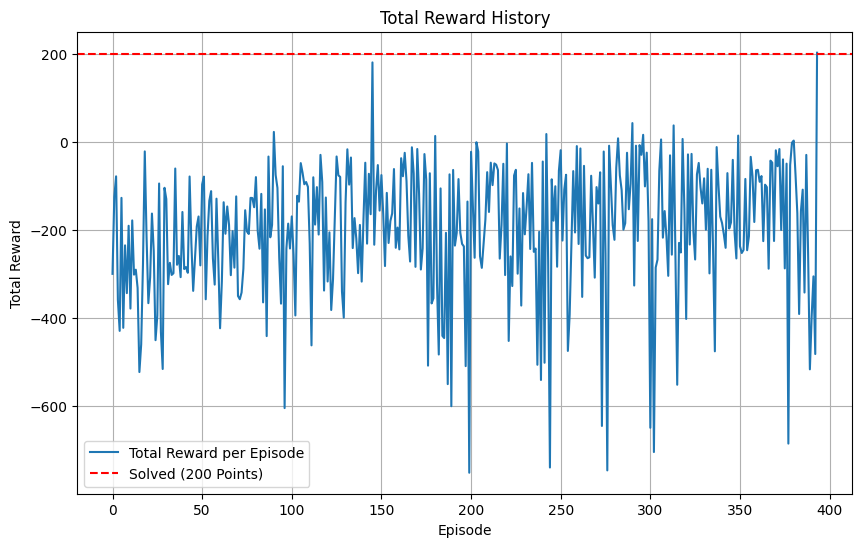

In [71]:
# Initialize the agent
agent = DQNAgent(state_size, action_size, GAMMA, EPSILON, EPSILON_MIN, EPSILON_DECAY)

# Warm-up phase to fill memory buffer
print("Filling memory...")
while len(agent.memory) < BATCH_SIZE:
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
print(f"Memory buffer filled with {len(agent.memory)} experiences. Executing training!!!")


# Begin agent training
total_reward_history = agent.train(EPISODES, TIME_STEPS, MINIMUM_REWARD)

env.close()  # Close the environment

# Plot the total reward history
plt.figure(figsize=(10, 6))
plt.plot(total_reward_history, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward History')
plt.grid(True)
plt.axhline(y=200, color='r', linestyle='--', label='Solved (200 Points)')
plt.legend()
plt.show()

In [11]:
# Load the trained agent
model_path = os.path.join("checkpoints", "model_best.keras")
trained_model = tf.keras.models.load_model(model_path)

In [31]:
# Make outputs directory to save video
os.makedirs("outputs", exist_ok=True)
video_path = os.path.join("outputs", "video.mp4")

# Create the environment
env = gym.make("LunarLander-v2")
video_recorder = VideoRecorder(env, path=video_path)

state = env.reset()
done = False

while not done:
    env.render()  # Render each frame
    video_recorder.capture_frame()
    state = np.array(state).reshape(1, -1)
    q_values = trained_model.predict(state, verbose=0)
    action = np.argmax(q_values[0])
    state, reward, done, _ = env.step(action)

# Close resources
env.close()
video_recorder.close()

In [35]:
# Render video
HTML(f"""
    <video width =640 height=480 alt="display_env" controls>
        <source src={video_path}" type="video/mp4">
    </video>
""")
